In [2]:
import json
import os
import sys
import pandas as pd
from bidict import bidict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from itertools import count
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from bokeh.io import output_notebook, reset_output
from bokeh.plotting import figure, show, ColumnDataSource, output_file
from bokeh.models import HoverTool

In [3]:
%matplotlib inline
sns.set()

In [4]:
data_path = "/data/rali7/Tmp/solimanz/data/model_predictions/top550/fasttext/"

In [5]:
path550 = "/data/rali7/Tmp/solimanz/data/datasets/top550/"
# Load data dicts
with open(os.path.join(path550, "jobid", "data.json"), "r") as f:
    data550 = json.load(f)

In [6]:
def next_batch(path):
    batch = 0
    name = os.path.basename(path)
    while os.path.exists(os.path.join(path, f"{name}_batch_{batch}.npy")):
        with open(os.path.join(path, f"{name}_batch_{batch}.npy"), "rb") as f:
            matrix = np.load(f)
        batch += 1
        yield matrix
        
def get_neural_data(dataset, data="hidden"):
    result_path = "/data/rali7/Tmp/solimanz/data/model_predictions"
    gen = next_batch(os.path.join(result_path, dataset, "fasttext", data))
    values = []
    
    for vals in gen:
        values.append(vals)
    
    values = np.concatenate(values)
    
    return values

In [7]:
hidden_states = get_neural_data("top550")
seq_lengths = get_neural_data("top550", "seq_lengths")
targets = get_neural_data("top550", "targets")

In [8]:
hidden_states = [row[:seq_len,:] for row, seq_len in zip(hidden_states, seq_lengths)]
targets = [np.argmax(row[:seq_len,:], axis=1) for row, seq_len in zip(targets, seq_lengths)]

In [8]:
all([all(np.equal(d[1][1:], t)) for d, t in zip(data550["test_data"], targets)])

True

In [9]:
stacked_hidden = np.concatenate(hidden_states)
stacked_targets = np.concatenate(targets)

In [16]:
last_hidden = np.array([hs[-1] for hs in hidden_states])
last_targets = np.array([ts[-1] for ts in targets])

In [11]:
by_length = dict()
for length in np.unique(seq_lengths):
    by_length[length] = last_hidden[np.where(seq_lengths == length)[0]]

In [12]:
by_target = dict()
for target in np.unique(last_targets):
    by_target[target] = last_hidden[np.where(last_targets == target)[0]]

In [13]:
pca = PCA(n_components=25)
pca_result = pca.fit_transform(stacked_hidden)
print(f'Variance PCA: {np.sum(pca.explained_variance_ratio_)}')

Variance PCA: 0.8423899412155151


In [19]:
tsne = TSNE(n_components=2, verbose = 1, perplexity=60, n_iter=5000, metric='cosine')
tsne_results = tsne.fit_transform(last_hidden)
#tsne_results = tsne.fit_transform(stacked_hidden[np.random.randint(stacked_hidden.shape[0], 
#                                                                   size=1000)])

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 24121 samples in 0.001s...
[t-SNE] Computed neighbors for 24121 samples in 17.863s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24121
[t-SNE] Computed conditional probabilities for sample 2000 / 24121
[t-SNE] Computed conditional probabilities for sample 3000 / 24121
[t-SNE] Computed conditional probabilities for sample 4000 / 24121
[t-SNE] Computed conditional probabilities for sample 5000 / 24121
[t-SNE] Computed conditional probabilities for sample 6000 / 24121
[t-SNE] Computed conditional probabilities for sample 7000 / 24121
[t-SNE] Computed conditional probabilities for sample 8000 / 24121
[t-SNE] Computed conditional probabilities for sample 9000 / 24121
[t-SNE] Computed conditional probabilities for sample 10000 / 24121
[t-SNE] Computed conditional probabilities for sample 11000 / 24121
[t-SNE] Computed conditional probabilities for sample 12000 / 24121
[t-SNE] Computed conditional probabilities for s

In [21]:
print("s")

s


In [8]:
df_dict = defaultdict(list)
for hidden_seq, targ_seq in zip(hidden_states, targets):
    for i, h, t in zip(count(), hidden_seq, targ_seq):   
        for j, neuron_value in enumerate(h):
            df_dict["target"].append(t)
            df_dict["length"].append(i + 1)     
            df_dict["value"].append(neuron_value)
            df_dict["neuron"].append(j)

In [9]:
df = pd.DataFrame(df_dict)

In [10]:
df.value = df.value.apply(np.sign)

In [18]:
plt.rcParams["figure.figsize"] = (30,15)

In [11]:
df.head()

,length,neuron,target,value
0,1,0,8,1.0
1,1,1,8,-1.0
2,1,2,8,1.0
3,1,3,8,-1.0
4,1,4,8,-1.0


In [25]:
data550.keys()

dict_keys(['title_to_id', 'train_data', 'test_data', 'maximum_seq_len'])

In [30]:
data550["test_data"][0]

['55ef65cc0b0451c87b93a1af', [8, 8, 8]]

In [31]:
title_id = bidict(data550["title_to_id"])
histories = [[title_id.inv[i] for i in seq[1][:-1]] for seq in data550["test_data"]]

In [33]:
data550["test_data"][11991]

['55e762010b04514a0b962783', [224, 224, 224]]

In [40]:
output_file("embeddings.html")
source1 = ColumnDataSource(data=dict(
    x=[p[0] for i, p in enumerate(tsne_results) 
       if "engineer" in title_id.inv[last_targets[i]] 
       and "software" not in title_id.inv[last_targets[i]]],
    y=[p[1] for i, p in enumerate(tsne_results)
      if "engineer" in title_id.inv[last_targets[i]] 
       and "software" not in title_id.inv[last_targets[i]]],
    desc=[title_id.inv[t] for t in last_targets
         if "engineer" in title_id.inv[t]
         and "software" not in title_id.inv[t]],
    hist=histories
))

source2 = ColumnDataSource(data=dict(
    x=[p[0] for i, p in enumerate(tsne_results) 
       if "marketing" in title_id.inv[last_targets[i]]],
    y=[p[1] for i, p in enumerate(tsne_results)
      if "marketing" in title_id.inv[last_targets[i]]],
    desc=[title_id.inv[t] for t in last_targets
         if "marketing" in title_id.inv[t]],
    hist=histories
))

source3 = ColumnDataSource(data=dict(
    x=[p[0] for i, p in enumerate(tsne_results) 
       if "chief" in title_id.inv[last_targets[i]] 
       and "officer" in title_id.inv[last_targets[i]]
       and "finance" not in title_id.inv[last_targets[i]]],
    y=[p[1] for i, p in enumerate(tsne_results)
      if "chief" in title_id.inv[last_targets[i]] 
       and "officer" in title_id.inv[last_targets[i]]
      and "finance" not in title_id.inv[last_targets[i]]],
    desc=[title_id.inv[t] for t in last_targets
         if "chief" in title_id.inv[t]
         and "officer" in title_id.inv[t]
         and "finance" not in title_id.inv[t]],
    hist=histories
))

source4 = ColumnDataSource(data=dict(
    x=[p[0] for i, p in enumerate(tsne_results) 
       if "chief" in title_id.inv[last_targets[i]] 
       and "finance" in title_id.inv[last_targets[i]]],
    y=[p[1] for i, p in enumerate(tsne_results)
      if "chief" in title_id.inv[last_targets[i]] 
       and "finance" in title_id.inv[last_targets[i]]],
    desc=[title_id.inv[t] for t in last_targets
         if "chief" in title_id.inv[t]
         and "finance" in title_id.inv[t]],
    hist=histories
))

source5 = ColumnDataSource(data=dict(
    x=[p[0] for i, p in enumerate(tsne_results) 
       if "engineer" in title_id.inv[last_targets[i]] 
       and "software" in title_id.inv[last_targets[i]]],
    y=[p[1] for i, p in enumerate(tsne_results)
      if "engineer" in title_id.inv[last_targets[i]] 
       and "software" in title_id.inv[last_targets[i]]],
    desc=[title_id.inv[t] for t in last_targets
         if "engineer" in title_id.inv[t]
         and "software" in title_id.inv[t]],
    hist=histories
))


hover = HoverTool( tooltips="""
    <div style ="border-style: solid;border-width: 2px;background-color:white;">         
        <div>
            <div style="font-size: 12px; color: black;font-family:sans-serif;">Index: $index</div>
            <div style="font-size: 12px; color: black;font-family:sans-serif;">Coords: ($x, $y)</div>
            <div style="font-size: 12px; color: black;font-family:sans-serif;">Desc: @desc</div>
            <div style="font-size: 12px; color: black;font-family:sans-serif;">Exp: @hist</div>
        </div>
    </div>
""")

p = figure(plot_width=1500, plot_height=800, tools = "pan,wheel_zoom,box_zoom,reset")
p.add_tools(hover)
p.circle('x', 'y', size=6, source=source1, color="navy")
#p.circle('x', 'y', size=6, source=source2, color="red")
p.circle('x', 'y', size=6, source=source3, color="limegreen")
p.circle('x', 'y', size=6, source=source4, color="darkolivegreen")
p.circle('x', 'y', size=6, source=source5, color="cyan")

show(p)

/u/solimanz/development/career_prediction_gpu/lib/python3.6/site-packages/bokeh/models/sources.py:114: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('desc', 428), ('hist', 24121), ('x', 428), ('y', 428)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))
/u/solimanz/development/career_prediction_gpu/lib/python3.6/site-packages/bokeh/models/sources.py:114: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('desc', 248), ('hist', 24121), ('x', 248), ('y', 248)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))
/u/solimanz/development/career_prediction_gpu/lib/python3.6/site-packages/bokeh/models/sources.py:114: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('desc', 300), ('hist', 24121), ('x', 300), ('y', 300)
  "Current lengths: %s" % ", ".join(sorted

In [ ]:
print('a"')

In [23]:
plt.rcParams["figure.figsize"] = (25,100)

In [22]:
sns.heatmap(hidden_states[15807], cbar=False, cmap='RdBu')

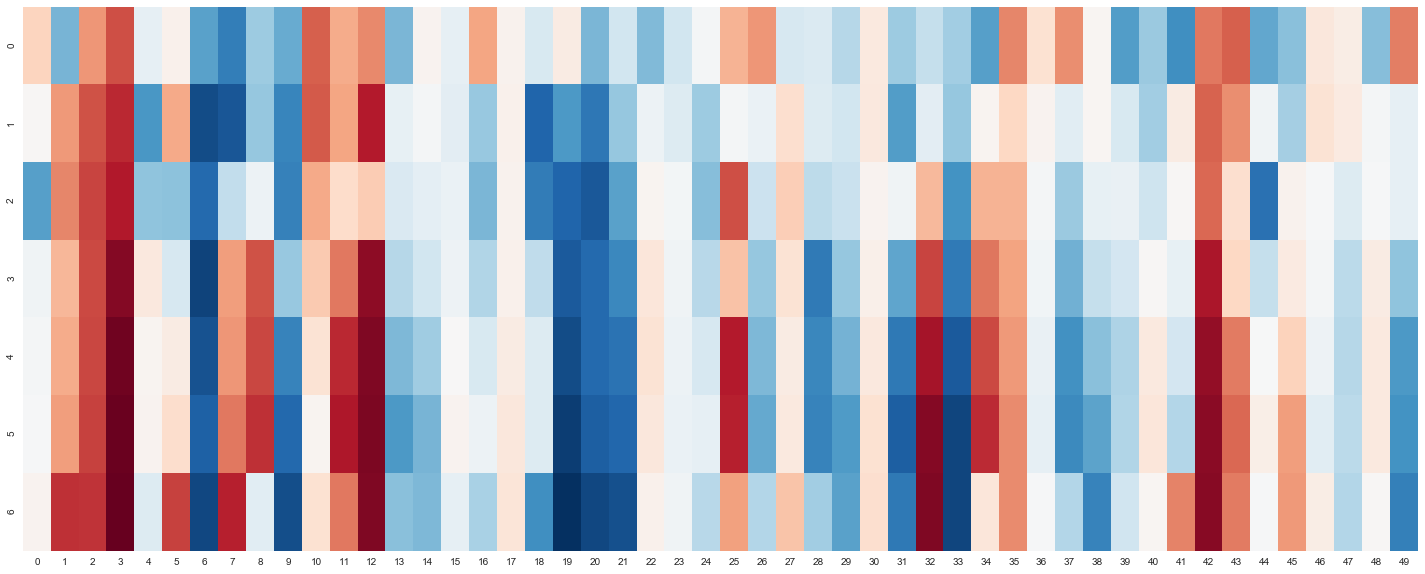

In [79]:
sns.heatmap(hidden_states[21751], cbar=False, cmap='RdBu')

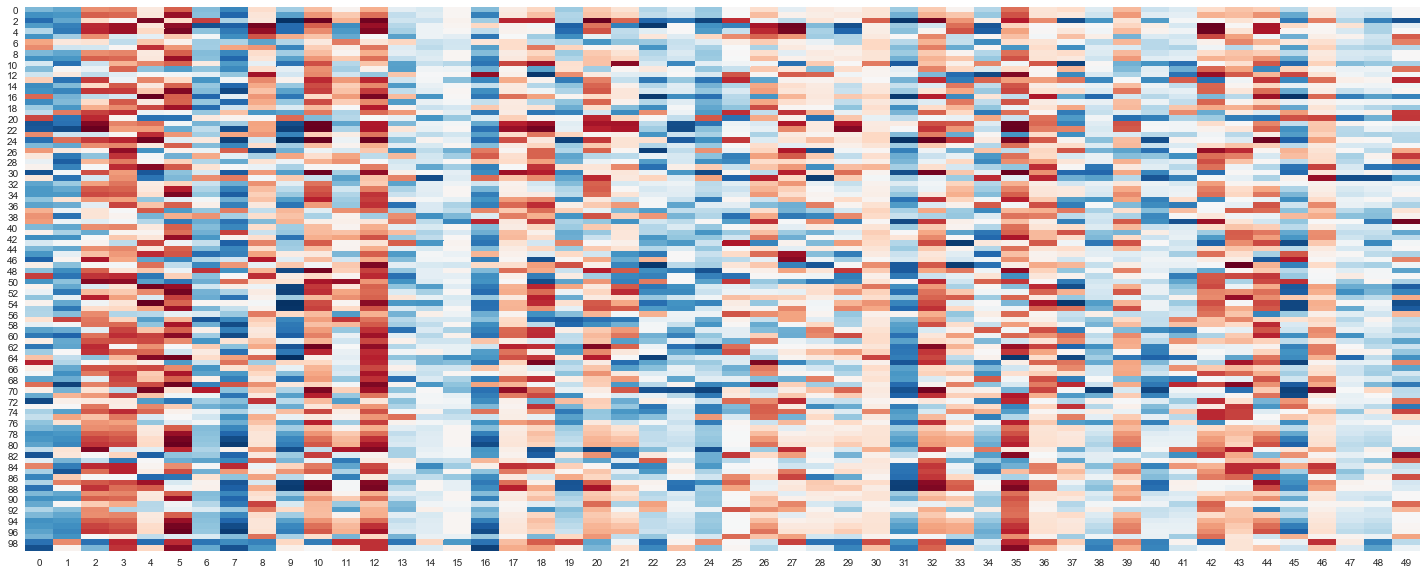

In [85]:
sns.heatmap(stacked_hidden[np.where(stacked_targets == 8)[0]][:100], cbar=False, cmap='RdBu')

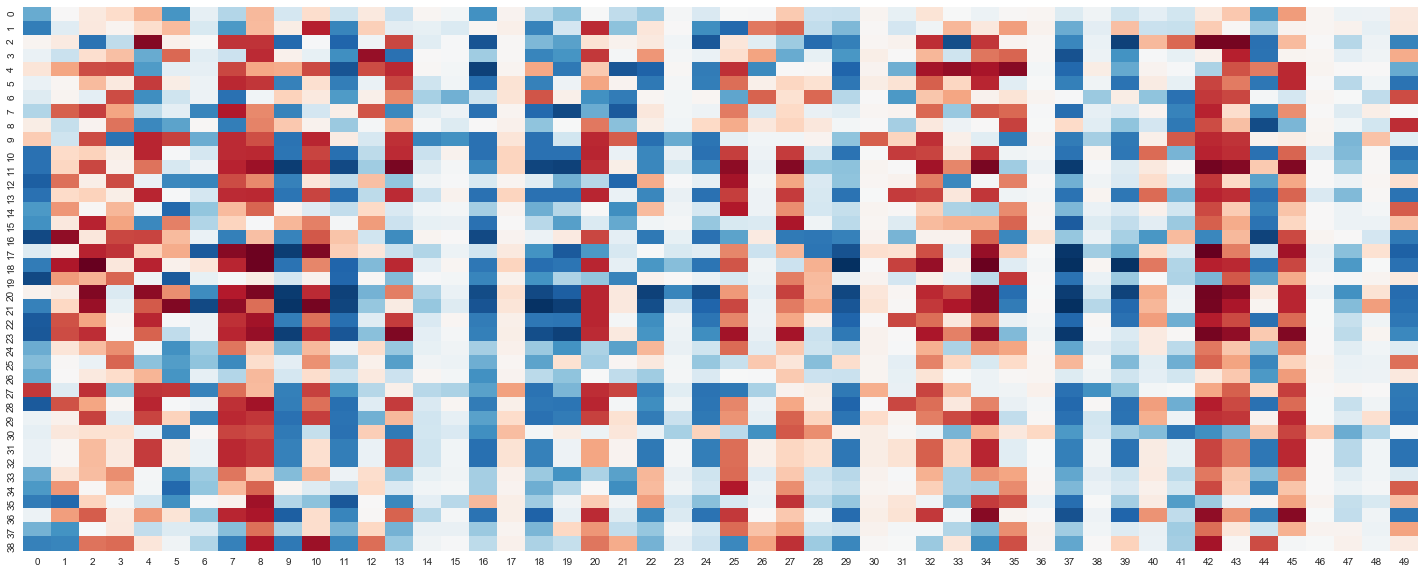

In [86]:
sns.heatmap(stacked_hidden[np.where(stacked_targets == 300)[0]][:100], cbar=False, cmap='RdBu')

In [10]:
lst = []
for i in np.unique(stacked_targets):
    lst.append(stacked_hidden[np.where(stacked_targets == i)[0]])

In [11]:
lst = np.concatenate(lst)